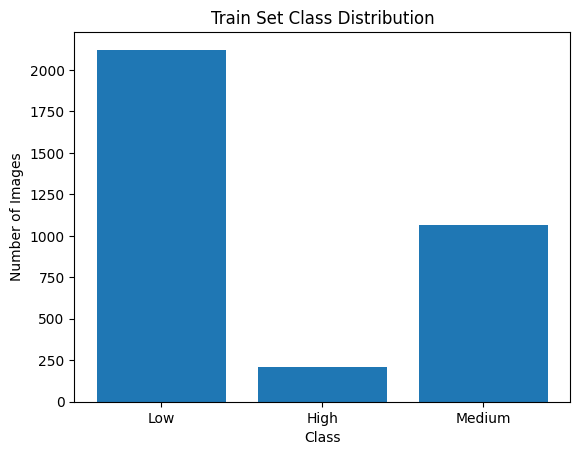

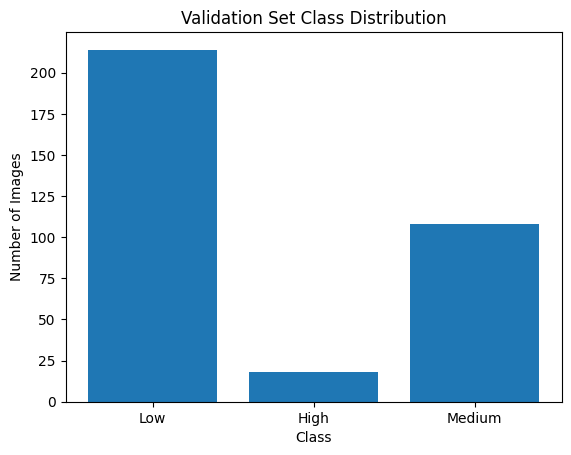

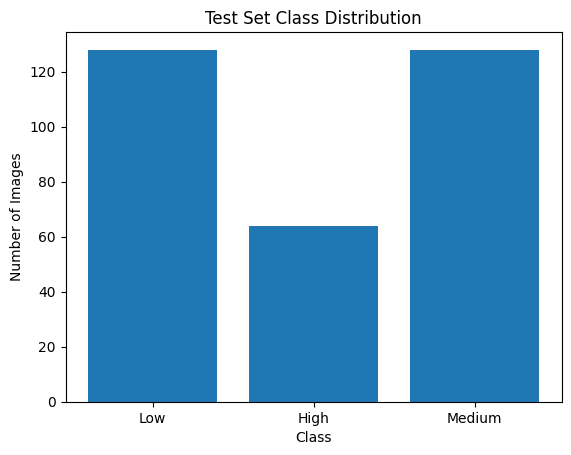

In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Function to count images in each class
def count_images(folder):
    class_counts = {}
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Paths to train, validation, and test folders
train_folder = '/kaggle/input/ssalis-traffic-density/Final Dataset/training'
val_folder = '/kaggle/input/ssalis-traffic-density/Final Dataset/validation'
test_folder = '/kaggle/input/ssalis-traffic-density/Final Dataset/testing'

# Count images in each folder
train_counts = count_images(train_folder)
val_counts = count_images(val_folder)
test_counts = count_images(test_folder)

# Plot class distribution
def plot_class_distribution(counts, title):
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

plot_class_distribution(train_counts, 'Train Set Class Distribution')
plot_class_distribution(val_counts, 'Validation Set Class Distribution')
plot_class_distribution(test_counts, 'Test Set Class Distribution')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 3397 images belonging to 3 classes.
Found 340 images belonging to 3 classes.
Found 320 images belonging to 3 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Model 1: Basic CNN
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: High, Medium, Low
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: ResNet50
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: VGG16
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 4: EfficientNetB0
def build_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 5: Random Forest with Image Features
def build_random_forest():
    # Extract features using ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    features = base_model.predict(train_generator)
    X_train = features.reshape(features.shape[0], -1)
    y_train = train_generator.classes

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    return rf_model

# Model 6: XGBoost with Image Features
def build_xgboost():
    # Extract features using ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    features = base_model.predict(train_generator)
    X_train = features.reshape(features.shape[0], -1)
    y_train = train_generator.classes

    # Train XGBoost
    xgb_model = XGBClassifier(n_estimators=100)
    xgb_model.fit(X_train, y_train)
    return xgb_model

# Model 7: Ensemble Model
def build_ensemble(models):
    # Combine predictions using a voting classifier
    ensemble = VotingClassifier(estimators=[(f'model_{i}', model) for i, model in enumerate(models)], voting='soft')
    return ensemble

In [4]:
# Train and evaluate each model
models = {
    'CNN': build_cnn(),
    'ResNet50': build_resnet50(),
    'VGG16': build_vgg16(),
    'EfficientNetB0': build_efficientnet(),
    'RandomForest': build_random_forest(),
    'XGBoost': build_xgboost()
}

# Train deep learning models
for name, model in models.items():
    if name in ['CNN', 'ResNet50', 'VGG16', 'EfficientNetB0']:
        print(f'Training {name}...')
        model.fit(train_generator, epochs=10, validation_data=val_generator)
        print(f'Finished training {name}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 502ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 46s 404ms/step
Training CNN...
Epoch 1/10
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6060 - loss: 1.9314

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 51s 414ms/step - accuracy: 0.6068 - loss: 1.9152 - val_accuracy: 0.7029 - val_loss: 0.6082
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.7044 - loss: 0.6555 - val_accuracy: 0.7765 - val_loss: 0.5235
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - accuracy: 0.7354 - loss: 0.5959 - val_accuracy: 0.7294 - val_loss: 0.7000
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 362ms/step - accuracy: 0.7403 - loss: 0.5755 - val_accuracy: 0.7500 - val_loss: 0.5966
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.7602 - loss: 0.5228 - val_accuracy: 0.7353 - val_loss: 0.7350
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.7952 - loss: 0.4844 - val_accuracy: 0.7235 - val_loss: 0.7456
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.7804 - loss: 0.5086 - val_accuracy: 0.6529 - val_loss: 0.9469
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 365ms/step - accuracy: 0.7959 - loss: 0.4535 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
Results for CNN:
              precision    recall  f1-score   support

        High       0.95      0.55      0.69        64
         Low       0.83      0.79      0.81       128
      Medium       0.70      0.89      0.79       128

    accuracy                           0.78       320
   macro avg       0.83      0.74      0.76       320
weighted avg       0.80      0.78      0.78       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


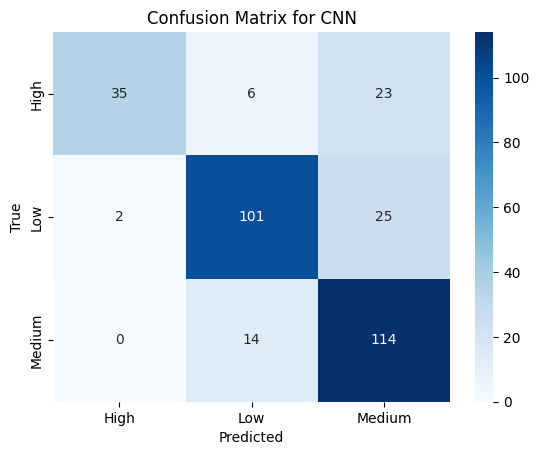

Results for ResNet50:
              precision    recall  f1-score   support

        High       1.00      0.36      0.53        64
         Low       0.92      0.93      0.92       128
      Medium       0.72      0.94      0.81       128

    accuracy                           0.82       320
   macro avg       0.88      0.74      0.75       320
weighted avg       0.85      0.82      0.80       320



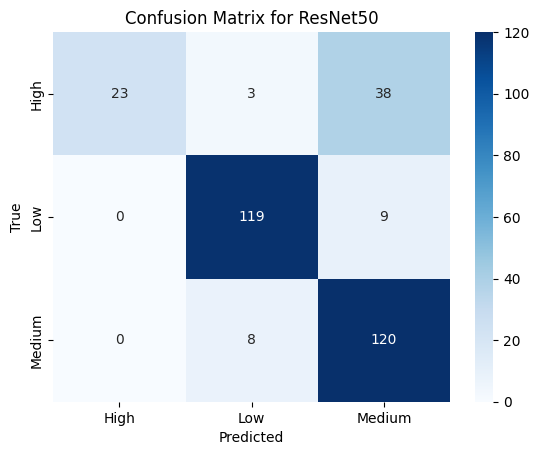

Results for VGG16:
              precision    recall  f1-score   support

        High       0.98      0.86      0.92        64
         Low       0.77      0.99      0.87       128
      Medium       0.97      0.75      0.85       128

    accuracy                           0.87       320
   macro avg       0.91      0.87      0.88       320
weighted avg       0.89      0.87      0.87       320



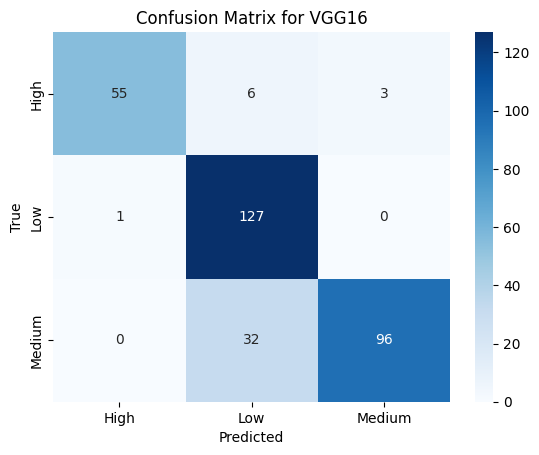

Results for EfficientNetB0:
              precision    recall  f1-score   support

        High       1.00      0.92      0.96        64
         Low       0.84      1.00      0.91       128
      Medium       0.95      0.80      0.87       128

    accuracy                           0.91       320
   macro avg       0.93      0.91      0.91       320
weighted avg       0.92      0.91      0.91       320



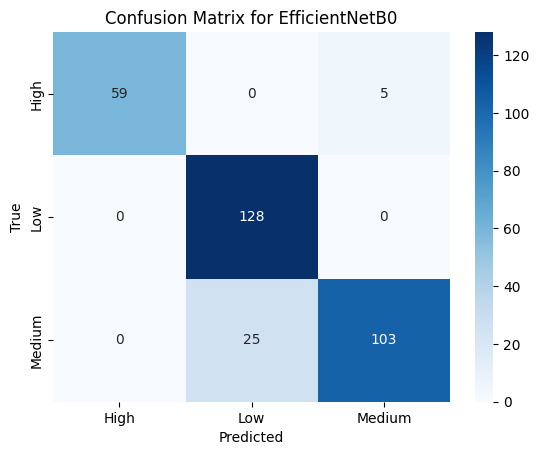

Results for RandomForest:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        64
         Low       0.40      0.98      0.57       128
      Medium       0.10      0.01      0.01       128

    accuracy                           0.39       320
   macro avg       0.17      0.33      0.20       320
weighted avg       0.20      0.39      0.23       320



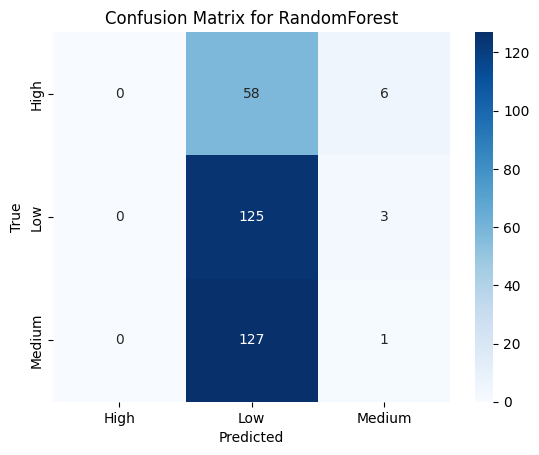

Results for XGBoost:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        64
         Low       0.40      0.92      0.56       128
      Medium       0.52      0.10      0.17       128

    accuracy                           0.41       320
   macro avg       0.31      0.34      0.24       320
weighted avg       0.37      0.41      0.29       320



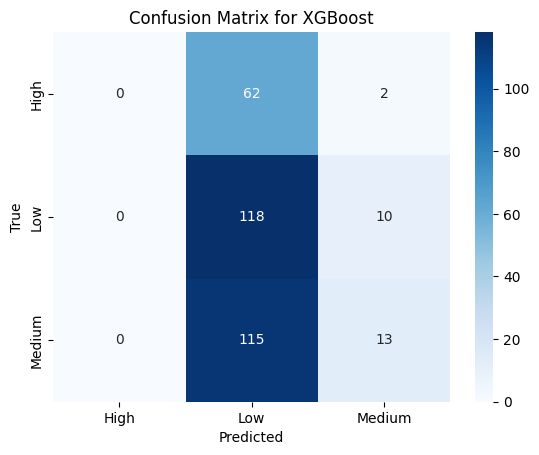

In [5]:
# Evaluate models on the test set
results = {}
for name, model in models.items():
    if name in ['CNN', 'ResNet50', 'VGG16', 'EfficientNetB0']:
        y_pred = model.predict(test_generator).argmax(axis=1)
    else:
        # Extract features for Random Forest and XGBoost
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        features = base_model.predict(test_generator)
        X_test = features.reshape(features.shape[0], -1)
        y_pred = model.predict(X_test)

    y_true = test_generator.classes
    results[name] = {
        'classification_report': classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

# Print classification reports and confusion matrices
for name, result in results.items():
    print(f'Results for {name}:')
    print(result['classification_report'])
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

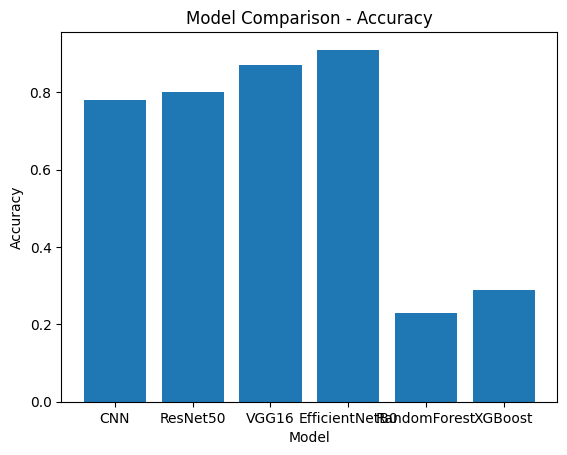

In [6]:
# Compare models based on accuracy
accuracies = {}
for name, result in results.items():
    report = result['classification_report']
    accuracy = float(report.split()[-2])  # Extract accuracy from the report
    accuracies[name] = accuracy

# Plot comparison
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()